# Guassian Processes for Emulators Tutorial
## Arizona Lensing Day Fall 2024
#### Connor Sweeney and Andres Salcedo

In this tutorial, we'll cover some of the basics of Gaussian Processes and how you might use them to construct an emulator. 
By the end of our session, you should have a better idea of what makes this method useful and when/how to use them effectively.


In [ ]:
#Install these packages if you haven't already. Execute these in a terminal if this is giving trouble.
%conda install scipy
%conda install -c conda-forge scikit-learn
%conda install -c conda-forge emcee
%pip install corner

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Imports==========================================================================================================
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as A
from numpy.random import RandomState
from scipy.stats import norm, multivariate_normal
import emcee
import corner

#Some Style stuff
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
matplotlib.rcParams.update({'text.usetex': True,   #Comment out if having trouble with tex
                            'font.family': 'New Century Schoolbook',
                            'font.size':20, 
                            'figure.dpi': 150, 
                            #'figure.figsize': (5, 5)
                            })

### Preliminary Background: 1D and Multivariate Gaussians, Bayesian Regression

A random variable $x$ that follows a Gaussian Distribution has the density function 
$$p(x|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\mathrm{exp}\left (-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}\right )$$ 

with a mean $\mu$ and variance $\sigma^2$. This should look familiar:

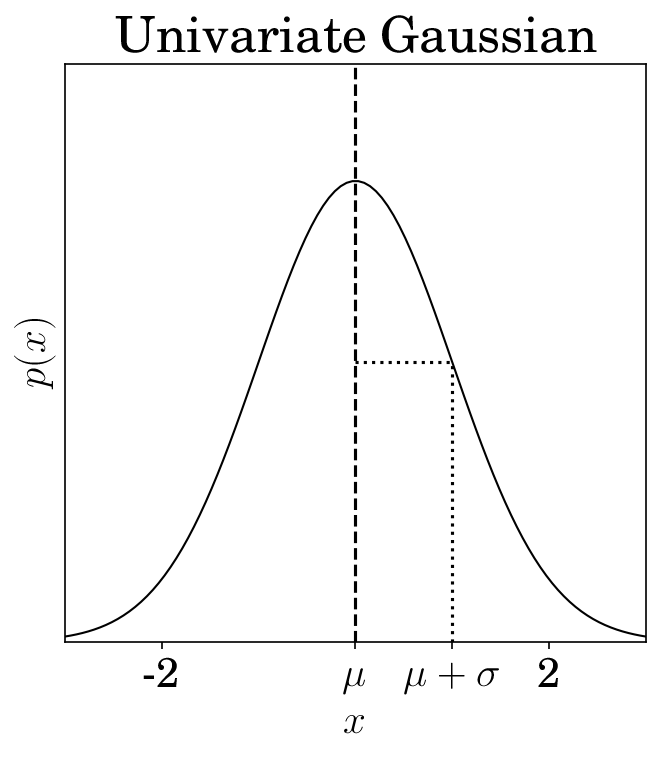

In [99]:

xs = np.linspace(-3, 3, 100)
mu = 0
s  = 1
pdf = norm.pdf(xs, mu, s)

plt.figure(figsize=(5, 5))
plt.plot(xs, pdf, '-k', lw=1)
plt.axvline(0, ls='--', color='k')
plt.hlines(norm.pdf(mu+s, mu, s), mu, mu+s, ls=':', color='k')
plt.vlines(mu+s, 0 , norm.pdf(mu+s, mu, s), ls=':', color='k')
plt.xlabel(r"$x$")
plt.ylabel(r"$p(x)$")
plt.title("Univariate Gaussian")
plt.yticks([])
plt.xticks([-2, 0, 1, 2], [-2, r"$\mu$", r"$\mu+\sigma$", 2])
plt.ylim((0, 0.5))
plt.margins(x=0)
plt.show() 

Similarly, a random *vector* variable $\bf{x} = [x_1, x_2, \ldots, x_n]^T$ that follows a multivariate Gaussian distribution has the density 

$$ p(\mathbf{x}|\boldsymbol{\mu}, \mathbf{\Sigma}) = \frac{1}{(2\pi)^{n/2}|\mathbf{\Sigma}|^{1/2}}\mathrm{exp}\left ( -\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right )$$

with mean $\boldsymbol{\mu}=[\mu_1, \mu_2, \ldots, \mu_n]^T$ and covariance *matrix* $\mathbf{\Sigma}= \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}$, which is symmetric and positive definite. The plot below shows an example bivariate Gaussian. We can see that both the marginal and conditional distributions are also Gaussians: 


Text(0.5, 0, '$P(y)$')

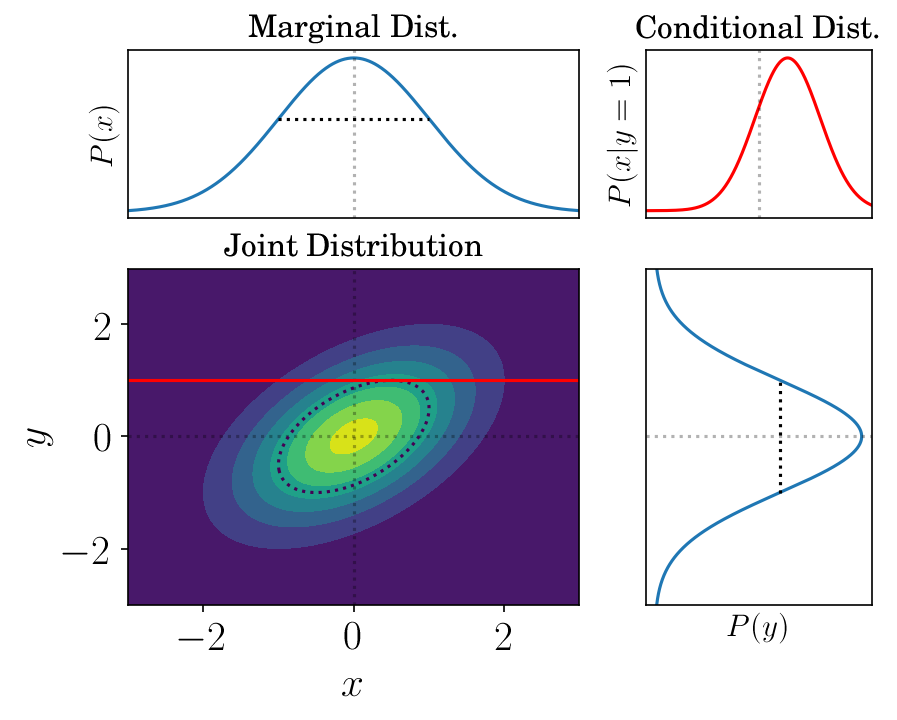

In [ ]:

fig, ax = plt.subplots(2, 2, gridspec_kw=dict(height_ratios=[1, 2],
                                          width_ratios=[2, 1]))
X, Y = np.mgrid[-3:3:.01, -3:3:.01]
XY = np.dstack((X, Y))
MVG = multivariate_normal.pdf(x=XY, mean=[mu, mu], cov=[[s, 0.5], [0.5, s]] )

ax[1, 0].contourf(X, Y, MVG, zorder=0.5)
ax[1, 0].axhline(0, color='k', alpha=0.3, ls=':')
ax[1, 0].axvline(0, color='k', alpha=0.3, ls=':')
ax[1, 0].contour(X, Y, MVG, levels=[np.max(MVG)*np.exp(-0.5)], linestyles=':', zorder=2.0)
ax[1, 0].axhline(1, color='r')
ax[1, 0].set_xlabel(r"$x$")
ax[1, 0].set_ylabel(r"$y$")
ax[1, 0].set_title(r"Joint Distribution", fontsize=15)

ax[0, 0].plot(X[:, 0], MVG.sum(axis=0))
ax[0, 0].axvline(0, color='k', alpha=0.3, ls=':')
ax[0, 0].hlines(np.max(MVG.sum(axis=0))*np.exp(-0.5), mu-s, mu+s, ls=':', color='k')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].margins(x=0)
ax[0, 0].set_ylabel(r"$P(x)$", fontsize=15)
ax[0, 0].set_title(r"Marginal Dist.", fontsize=15)

ax[0, 1].plot(X[:, 450], MVG[:, 450]/MVG[:, 450].sum(),  color='red')
ax[0, 1].axvline(0, color='k', alpha=0.3, ls=':')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 1].margins(x=0)
ax[0, 1].set_ylabel(r"$P(x|y=1)$", fontsize=15)
ax[0, 1].set_title(r"Conditional Dist.", fontsize=15)

ax[1, 1].plot(MVG.sum(axis=1), Y[0, :])
ax[1, 1].axhline(0, color='k', alpha=0.3, ls=':')
ax[1, 1].vlines(np.max(MVG.sum(axis=0))*np.exp(-0.5), mu-s, mu+s, ls=':', color='k')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 1].margins(y=0)
ax[1, 1].set_xlabel(r"$P(y)$", fontsize=15)


The conditional distribution for the bivariate case is 
$$\begin{aligned}
p(x|y) &= \frac{p(x, y)}{p(y)}
       &= \frac{1}{\sqrt{2\pi\sigma_x^2(1-\rho^2)}}\mathrm{exp}\left ( -\frac{1}{2}\frac{[x-\mu_x-\rho\frac{\sigma_x}{\sigma_y}(y-\mu_y)]}{\sigma_x^2(1-\rho^2)}\right )
\end{aligned}$$ 
where $\rho = \frac{\mathrm{cov}(x, y)}{\sigma_x\sigma_y}$. More generally, for  $\mathbf{x} = [\mathbf{x}_1 \ \mathbf{x}_2]^T$, $\boldsymbol{\mu} = [\boldsymbol{\mu}_1 \ \boldsymbol{\mu}_2]^T$ and $\mathbf{\Sigma}= \begin{bmatrix}
  \mathbf{\Sigma_{11}} & \mathbf{\Sigma_{12}}  \\
  \mathbf{\Sigma_{21}} &\mathbf{\Sigma_{22}}  \\
 \end{bmatrix}$, we have 
$$ \mathbf{x_1}|\mathbf{x_2} \sim \mathcal{N}(\bar{ \boldsymbol{\mu}}, \bar{ \mathbf{\Sigma}}) $$ 

where $\bar{ \boldsymbol{\mu}} = \boldsymbol{\mu_1}+\mathbf{\Sigma}_{12}\mathbf{\Sigma}_{22}^{-1}(\mathbf{x_2-\boldsymbol{\mu}_2})$ and $\bar{ \mathbf{\Sigma}} = \mathbf{\Sigma}_{11} -\mathbf{\Sigma}_{12}\mathbf{\Sigma}_{22}^{-1}\mathbf{\Sigma}_{21}$ . 

### Gaussian Processes Background
So, *what is a gaussian process?* A typical definition is as follows:

>*A Gaussian process is a collection of random variables, any
finite number of which have a joint Gaussian distribution.* 
> - Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006

This is a broad definition. In our case, where we want to construct an emulator to fit some data, we are interested in treating the *functions* that could describe our data as a gaussian process (GP). i.e.: 

$$ f(\mathbf x) \sim \mathcal{N}( \mu, \Sigma) $$

For simplicity, the mean of this distribution, $\mu$, is typically set to zero or a constant. The GP is then determined by the properties of the *covariance function* $\Sigma$, also referred to as the *kernel*. A common covariance function is the so-called Radial Basis Function (or "Squared Exponential Kernel", or "Gaussian Kernel"):
$$ \mathrm{cov}(f_i, f_j) = k_{RBF}( x_i,  x_j) = A \ \mathrm{exp}\left (-\frac{1}{2}\frac{||x_i-x_j||^2}{\ell^2} \right )$$ 

The hyperparameters $A$ and $\ell$ set the covariance between points $f_i$ and $f_j$: $A$ controls the amplitude of the function variations and $\ell$ controls how quickly they vary in $x$.

Making our initial statement a bit more explicit, for a number of input data $x_1, x_2, ..., x_n$ with function values $f(x_1), f(x_2), ..., f(x_n)$, a Gaussian Process states that the joint distribution of these function values is a Gaussian 

$$ \begin{bmatrix}
    f(x_1)\\
    \vdots\\
    f(x_n)
\end{bmatrix} \sim \mathcal{N}\left ( \boldsymbol{\mu}, \begin{bmatrix}
k(x_1, x_1) &\ldots &k(x_1, x_n) \\
\vdots &\ddots &\vdots \\
k(x_n, x_1)& \ldots &k(x_n, x_n)\\

\end{bmatrix}\right ) $$ 

In other words, this is a *prior* on the data points we have observed. Ultimately we would like to use this to obtain a function $f(\mathbf x_*)$ on some test data points $\mathbf x_*$ from the posterior $P(f(\mathbf x_*)|f(\mathbf x), \mathbf x, \mathbf x_*)$. We obtain this from the Marginal and Conditional distributions (see the preliminaries), and ultimately end up with 

$$f(\mathbf x_*)|f(\mathbf x), \mathbf x, \mathbf x_* \sim \mathcal{N} \left ( \bar f_*, \mathrm{cov}(f_*) \right )$$

where 

$$\begin{align*} \bar f_* &= K(\mathbf x_*, \mathbf x)K(\mathbf x, \mathbf x)^{-1}f(\mathbf x), \\
\mathrm{cov}(f_*) &= K(\mathbf x_*, \mathbf x_*) - K(\mathbf x_*, \mathbf x) K(\mathbf x, \mathbf x)^{-1}K(\mathbf x, \mathbf x_*)
\end{align*}$$ 

$\bar f_*$ is our desired function to be evaluated at any test point $x_*$, which has an uncertainty $\mathrm{cov}(f_*)$. Below, we see an example using some sample data (without noise, for now). 

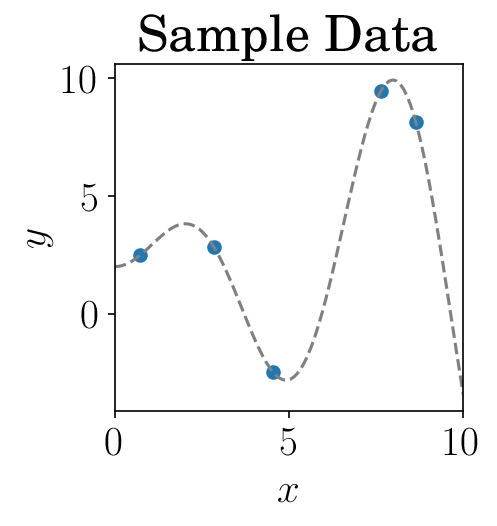

In [117]:
#Plot some sample data
RS = RandomState(29)

def NL_fcn(x):
    return 2+x*np.sin(x)

X_train = RS.uniform(0, 10, 5).reshape(-1, 1)
y_train = NL_fcn(X_train)
x = np.linspace(0, 10, 100)

plt.figure(figsize=(3, 3))
plt.scatter(X_train, y_train)
plt.plot(x, NL_fcn(x), ls='--', color="gray")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"Sample Data")
plt.margins(x=0)
plt.show()

Starting Kernel: 1**2 * RBF(length_scale=1)
Final Kernel: 5.09**2 * RBF(length_scale=1.45)


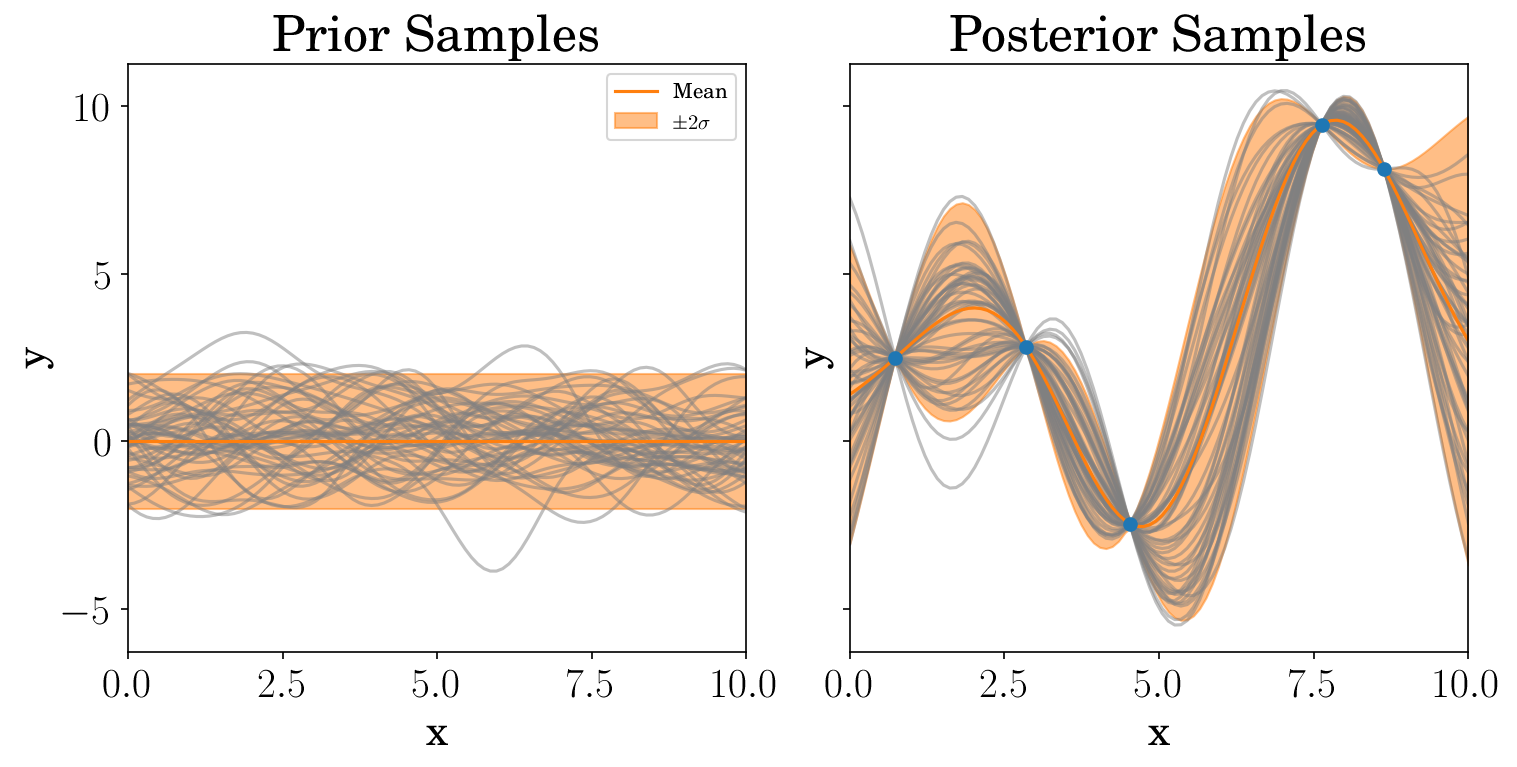

In [38]:

def plot_Pr_Post_samples(GP, X_train, y_train, ax, noise=None, n_samples=3):
    """Plot samples, mean, and 95% CI's from a given Guassian Process prior and posterior. 
        Samples from the prior are first obtained from the GP _before_ 
        training, and those from the posterior after. 
        Optimal hyperpearameters will be found while training unless 
        parameter bounds are indicated as 'fixed' in the kernel beforehand 
        (e.g. length_scale_bounds='fixed').         

    Args:
        GP (GaussianProcessRegressor): Instance of sklearn's gaussian_process.GaussianProcessRegressor. 
        X_train (np.ndarray): x values for training. 
        y_train (np.ndarray): y values for training.
        ax (matplotlib axis): Axes to plot the samples.
        noise (float or NoneType, optional): Noise to plot on training data, if present. Defaults to None.  
        n_samples (int, optional): Number of samples to plot. Defaults to 3.
    """
    #Plot Prior Samples
    X = np.linspace(0, 10, 100).reshape(-1, 1)

    y_mean, y_predict = GP.predict(X, return_std=True)
    samples = GP.sample_y(X, n_samples)
    print("Starting Kernel:",  GP.kernel)

    for i in range(n_samples):
        ax[0].plot(X[:, 0], samples[:, i], color='gray', alpha=0.5)

    ax[0].plot(X[:, 0], y_mean, color=cycle[1], label="Mean")
    ax[0].fill_between(X[:, 0], y_mean+2*y_predict, y_mean-2*y_predict, color=cycle[1], alpha=0.5, label=r"$\pm 2 \sigma$")

    ax[0].set_ylabel(r"y")
    ax[0].set_xlabel(r"x")
    ax[0].set_title(r"Prior Samples")
    ax[0].legend(fontsize=10)
    ax[0].margins(x=0)
    
    #Train GP on data 
    GP.fit(X_train, y_train)
    print("Final Kernel:", GP.kernel_)

    y_mean, y_predict = GP.predict(X, return_std=True)
    samples = GP.sample_y(X, n_samples)

    for i in range(n_samples):
        ax[1].plot(X[:, 0], samples[:, i], color='gray', alpha=0.5) 

    ax[1].plot(X[:, 0], y_mean, color=cycle[1])
    ax[1].fill_between(X[:, 0], y_mean+2*y_predict, y_mean-2*y_predict, color=cycle[1], alpha=0.5)
    ax[1].set_ylabel(r"y")
    ax[1].set_xlabel(r"x")
    ax[1].set_title(r"Posterior Samples")
    ax[1].margins(x=0)

    ax[1].errorbar(X_train.flatten(), y_train.flatten(), yerr=noise, fmt='o', color=cycle[0]) 

#Plot example prior and posterior with an RBF covariance function
CF = A(constant_value=1.0)*RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
GP = GaussianProcessRegressor(CF)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, layout="constrained")

plot_Pr_Post_samples(GP, X_train, y_train, n_samples=50, ax=ax)

## A bit more on Kernels

As we mentioned, the hyperparameters of the covariance function $k_{\rm RBF}(x_i, x_j)$ can be clearly interpreted as setting the amplitude and characteristic length of variation in our sampled functions. To see this ourselves, let's try changing the hyperparameters by hand. For each of the amplitude and length scale values below, plot samples, means, and error bands for each hyperparameter (while holding the other hyperparameter fixed). 

Note the changes you see, and discuss with your neighbors.

In [ ]:
#Inspect how adjusting hyperparamers adjusts posterior
a_s = [1.0, 5.0, 10.0]
l_s = [0.5, 1.4, 5.0]

### Your code below ###


As long as the covariance matrix for our joint distribution is positive definite, we can use any form of kernel we'd like. The RBF tends to be the most flexible and is easily interpreted, but there may be better kernels to use based on the qualities of your data (see [here](https://gaussianprocess.org/gpml/chapters/RW4.pdf) for more theory on kernels, integral transforms, and basis functions).  

Take a look at some of sklearn's implemented kernels (click [here](https://scikit-learn.org/1.5/api/sklearn.gaussian_process.html#:~:text=Kernels,in%20Gaussian%20processes.) for some) and try them out below. An important property of kernels that follows from them being PD is that linear combinations and products of kernels are *also* kernels. So, try combining a couple of kernels in some way and see what you can get:

In [ ]:
#Try experimenting with some other kernels 
from sklearn.gaussian_process.kernels import Matern, DotProduct, ExpSineSquared

### Your code below ###



## Incorporating Noise 

Real-world data often possesses noise in addition to any underlying relationship to inputs. We'll consider the addition of independent and identically distributed (i.i.d) Gaussian noise $\varepsilon$ with variance $\sigma_{\rm noise}^2$ to the underlying function above, so that our noisy outputs are $y = f(x)+\varepsilon$. 

Considering that for the noiseless case, the joint distribution between an observed value $f$ and a value at a test point $f_*$ is 
$$ \begin{pmatrix}
    f\\
    f_*
\end{pmatrix} \sim \mathcal{N}\left ( 0, 
\begin{bmatrix} 
k(x, x) &k(x, x_*) \\
k(x_*, x) &k(x_*, x_*) \\
\end{bmatrix} \right ) $$ 

__Q__: How should we modify the joint distribution to account for this noise?

<details>
the joint distribution between a *noisy* data point $y$ and a test point $f_*$ will be 

$$ \begin{pmatrix}
    y\\
    f_*
\end{pmatrix} \sim \mathcal{N}\left ( 0, 
\begin{bmatrix} 
k(x, x) + \sigma_{\rm noise}^2 &k(x, x_*) \\
k(x_*, x) &k(x_*, x_*) \\
\end{bmatrix} \right ) $$ 

This is due to the fact $y$ is a sum of two independent Gaussians with variance $k(x, x)$ and $\sigma_{\rm noise}^2$, respectively. 

</details>


__Q__: How does this change to the joint distribution change our expression for the GP posterior prediction? 

Modify the code for the first plot in this notebook to add i.i.d noise to the underlying function, and plot the noisy data with error bars.  

In [ ]:
###Your code Below: ####

#Generate Noisy data


With this in hand, let's plot the samples, means, and errobands for a GP as we have done before. Note that the sklearn GPR can handle noise by specifying `alpha=sigma_noise**2` when calling the `GuassianProcessRegressor`.

In [ ]:
###Your code Below: ####

#Fit Noisy Data by setting 'alpha' parameter in GPR


## Building an Emulator with GPs

To illustrate how we can use GPs for something like an emulator, we will walk through a simple example involving sample linear matter power spectrum data. 
The goal of an emulator is to essentially interpolate between data for which it is difficult to obtain many realizations (e.g. simulated cluster properties as a function of cosmology). We will work with $P(k)$ that has been generated for several realizations of $\Omega_m$ and $\sigma_8$, and use the GP to emulate them as a smooth function of these two parameters to get a (rough) example of this.

In [47]:
#Read in Pk_lin data and comso parameters used to generate
Pk_s = np.loadtxt("LHS_Pk.txt")
params = np.loadtxt("LHS_params.txt")

#Define range of k values 
k_s = np.logspace(np.log10(1e-5), np.log10(1e3), 6000)

In [48]:
#Prep data
from sklearn.model_selection import train_test_split
 
Omega_m_s, sigma_8_s = params[:, 0], params[:, 1]

pars = np.array([Omega_m_s, sigma_8_s]).T 

#Split samples into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(pars, Pk_s) 

#Choose Kernel and hyperparameters
kernel = A(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2) 

In [50]:
#Train GP
gp.fit(X_train, y_train)

/Users/connor/miniconda3/envs/gpenv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

Before moving on, let's inspect how well our trained GP can predict one of the $P(k)$ test samples. Below, plot one of the test samples and the prediction from the GP for the associated cosmological parameters, with errors on the estimate. 

Note that to evaluate the prediction at a specific test input, you can use `GP.predict(test_input, return_std=True)`. This also gives the standard deviation estimates. 

In [ ]:
###Your code Below: ####


How good does your prediction look? How might we improve our prediction, if needed?

Once you and your neighbors are done discussing, let's move on to using the GP for inference of $\Omega_m$ and $\sigma_8$.

In [77]:
#simple likelihood function
def log_likelihood(params, gp, obs_P_k):
    Omega_m, sigma_8 = params
    
    pred_mean= ### Your answer here ###
    log_like = -0.5 * np.sum(((obs_P_k - pred_mean)**2) ) 

    return log_like

n_points=y_test.shape[-1]

# Example "observed" data
obs_P_k = np.mean(y_test, axis=0) +1e-2*np.random.randn(n_points)

def log_prior(params):
    Omega_m, sigma_8 = params
    if 0.7 < sigma_8 < 1.0 and 0.2 < Omega_m < 0.35:
        return 0.0
    return -np.inf

def log_posterior(params, gp, obs_P_k):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, gp, obs_P_k)

#Sample Posterior with emcee
n_walkers = 12
n_dim = 2
initial_guess = [0.3, 0.8 ]  
pos = initial_guess + 0.01 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(gp, obs_P_k))

# Run the sampler
n_steps = 1000
sampler.run_mcmc(pos, n_steps, progress=True)

flat_samples = sampler.get_chain(discard=200, flat=True)


You must install the tqdm library to use progress indicators with emcee


'ax[2].set_xlim((0.25, 0.27))\nax[2].set_ylim((0.7, 0.8))\n\nax[0].set_xlim((0.25, 0.27))\nax[3].set_xlim((0.7, 0.8))'

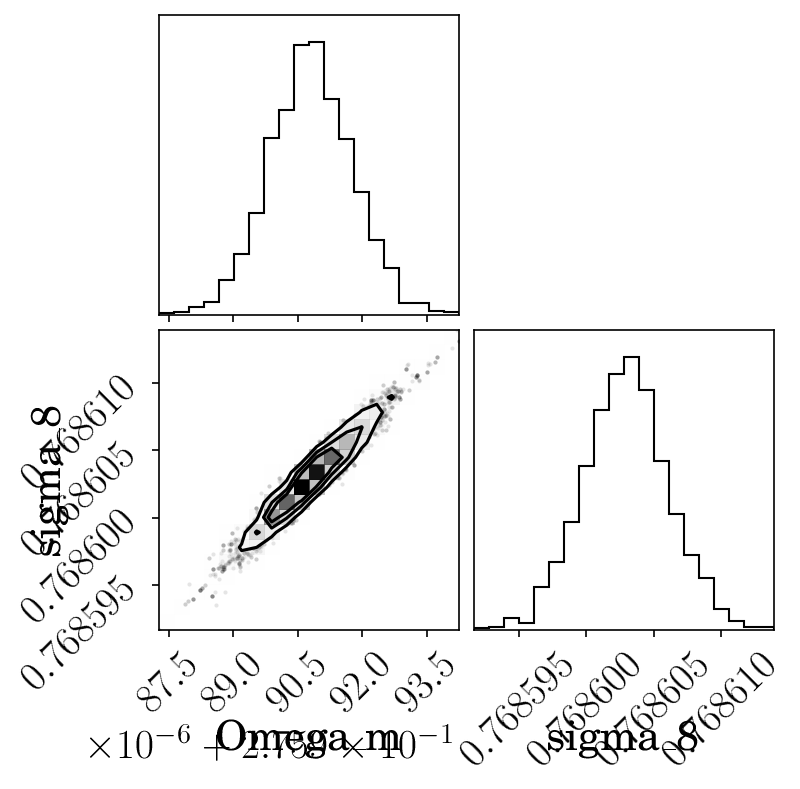

In [ ]:
# Plot posterior distributions

fig = corner.corner(flat_samples, labels=["Omega_m", "sigma_8"]) 
ax = fig.axes 

## References

All $P(k)$ data was generated by Andres Salcedo.  

https://gaussianprocess.org/gpml/chapters/

https://cs.stanford.edu/~rpryzant/blog/gp/gp.html 

https://www.d2l.ai/chapter_gaussian-processes/index.html 

https://arxiv.org/html/2009.10862v5 

https://cosmiccoding.com.au/tutorials/gaussian_processes/ 

https://gpss.cc/gpip/slides/rasmussen.pdf 

https://www.cosmologyfromhome.com/wp-content/uploads/2021/06/Parallel2021_Paula-Soares.pdf 

https://scikit-learn.org/1.5/modules/gaussian_process.html#gaussian-process 